# Worst-Case $\varepsilon$-Outage Capacity of Rayleigh Fading Channels

_Author:_ Karl-Ludwig Besser, Technische Universität Braunschweig

This notebook is part of the paper "Reliable Communications Over Dependent Fading Wireless Channels" ([arXiv:1909.01415[cs.IT]](https://arxiv.org/abs/1909.01415)).  
If you use any of this work, please cite the above paper.

## Introduction

In the following, the worst-case $\varepsilon$-capacity $\underline{R}^{\varepsilon}$ for Rayleigh fading channels is shown.

In the case of Rayleigh fading, all $\left|h\right|^2\sim\exp(1)$ are exponentially distributed.  
The final expression for $\underline{R}^{\varepsilon}$ is given by
$$\underline{R}^{\varepsilon}(\rho) = \log_2\left(1-\rho \cdot \phi_{-}(1-\varepsilon)\right),$$
where $\rho$ is the SNR and $\phi_{-}$ is derived from [[Wang et al., 2013, Eq. (3.9)]](https://doi.org/10.1007/s00780-012-0200-5) for $-X_i\sim\exp(1)$.  
Please refer to the paper for details.

The following code shows the (numerical) calculations.

_Note:_ The calculations for the best-case capacity $\overline{R}^{\varepsilon}$ are shown in the notebook [Best-Case Epsilon-Outage Capacity of Rayleigh Fading Channels](best-case-epsilon-outage-rayleigh.ipynb). A comparison of worst-case and best-case with iid and comonotonic cases is presented in the notebook [Outage Capacity Rayleigh Channel](Outage%20Capacity%20Rayleigh%20Channel.ipynb).

In [1]:
import numpy as np
from scipy import optimize
%matplotlib notebook
import matplotlib.pyplot as plt
from ipywidgets import interact

## Basic Functions

In [2]:
# Negative of the exponential distribution (increasing density)
def pdf(x):  # f_{-}
    return np.exp(x)

def cdf(x):  # F_{-}
    return np.exp(x)

def inv_cdf(x):  # G_{-}
    return np.log(x)

In [3]:
def H(x, n, a):  # H_{a}^{-}
    return inv_cdf(a+x) + (n-1)*inv_cdf(1-(n-1)*x)

def T(x, n, a):  # Integral of H_a^-(x)
    return -n*x + (a+x)*np.log(a+x) + ((n-1)*x-1)*np.log(1-(n-1)*x)

def psi(a):  # conditional expectation psi(a) = E[X|X > G(a)]
    if a == 0:
        return -1
    elif a == 1:
        return 0
    else:
        return (a-a*np.log(a)-1)/(1-a)

In [4]:
# Calculation of cmin [Wang et al., 2013, Eq. (3.7)]
def lhs_cmin(c, n, a):
    if a+c == 0:
        return 0
    else:
        return (a-1) + n*c - (a+c)*np.log(a+c) - ((n-1)*c-1)*np.log(1-(n-1)*c)

def rhs_cmin(c, n, a):
    return ((1-a)/n-c)*H(c, n, a)

def diff_cmin(c, n, a):  # since LHS <= RHS --> LHS-RHS <= 0
    return lhs_cmin(c, n, a) - rhs_cmin(c, n, a)

def determine_cmin(n, a):
    if (a > 0) and (diff_cmin(0, n, a) < 0):  # when inequality holds at c=0 --> cmin=0
        return 0
    _eps = np.finfo(float).eps
    x0 = ((1-a)/n+_eps)/2
    bracket = [0+_eps, (1-a)/(n*(n-1))]
    try:
        solution = optimize.root_scalar(diff_cmin, args=(n, a), x0=x0, bracket=bracket)
    except ValueError as e:
        print("Error during root solving for n={:d}, a={:.2f}: {}".format(n, a, e))
        return 1
    return solution.root

In [5]:
# Function phi_{-}(a) for increasing density
def phi(a, n, cmin=None):
    if cmin is None:
        cmin = determine_cmin(n, a)
    if cmin > 0:
        _phi = H(0, n, a)
    elif cmin == 0:
        _phi = n*psi(a)
    else:
        raise ValueError("cmin must not be negative!")
    return _phi

## Rate Calculation

The rate is derived from the following solution for the outage-capacity
$$s^{\star} = -\phi_{-}(1-\varepsilon) = \frac{2^{\underline{R}^{\varepsilon}}-1}{\rho}.$$

Please refer to the paper for details about this relation.

In [6]:
def calc_rate(eps, snr, n):
    return np.log2(1-snr*phi(1-eps, n))

## Plots of Different Relations

### Influence of a on c_n

<IPython.core.display.Javascript object>


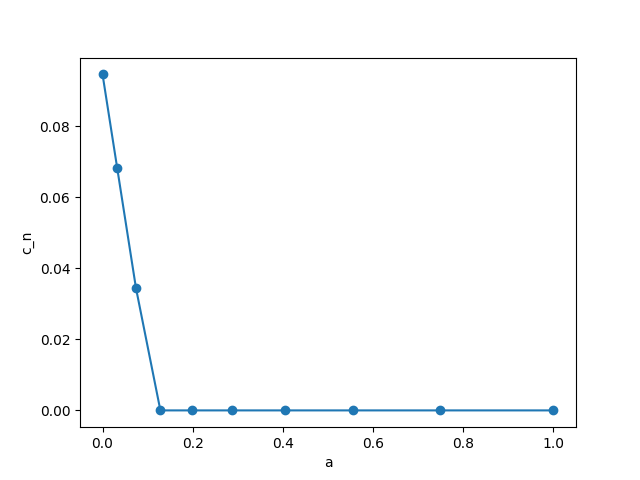

interactive(children=(IntSlider(value=3, description='n', max=10, min=3), Output()), _dom_classes=('widget-int…

In [7]:
def cmin_plot_a():
    fig, ax = plt.subplots(num="c_n vs a")
    ax.set_xlabel("a")
    ax.set_ylabel("c_n")
    a = (np.logspace(0, 1, 10)-1)/9
    cmin = [determine_cmin(3, _a) for _a in a]
    _plot = ax.plot(a, cmin, 'o-')[0]
    
    def update_plot(n=0):
        _plot.set_ydata([determine_cmin(n, _a) for _a in a])
        fig.canvas.draw_idle()
    
    interact(update_plot, n=(3, 10, 1))

cmin_plot_a()

It can be seen that $c_n$ decreases with increasing $a$ and increasing $n$. Above a certain $a$, $c_n$ is equal to zero. This threshold $a$ decreases with increasing $n$.

### Outage Rate

<IPython.core.display.Javascript object>


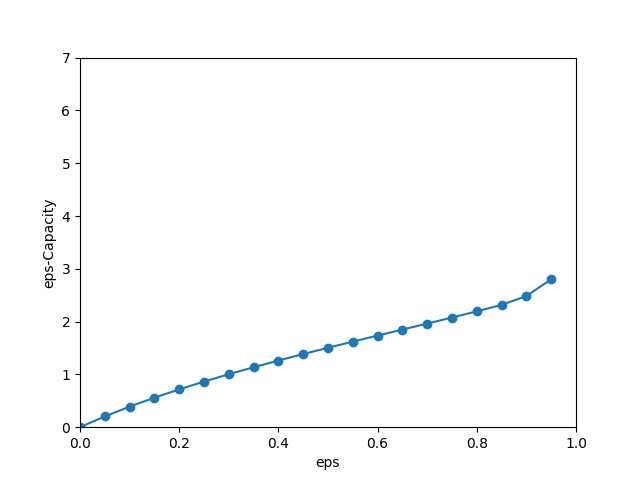

interactive(children=(IntSlider(value=3, description='n', max=10, min=3), IntSlider(value=3, description='snr_…

In [8]:
def outage_rate_plot(snr_init=3, n_init=3):
    fig, ax = plt.subplots(num='Worst-Case Epsilon-Outage Capacity')
    ax.set_ylabel("eps-Capacity")
    ax.set_xlabel("eps")
    eps = np.arange(0, 1, .05)
    _rate = [calc_rate(_eps, snr_init, n_init) for _eps in eps]
    _plot = ax.plot(eps, _rate, 'o-')[0]
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 7])

    def update_plot(n=n_init, snr_db=snr_init):
        snr = 10**(snr_db/10.)
        _plot.set_ydata([calc_rate(_eps, snr, n) for _eps in eps])
        fig.canvas.draw_idle()

    interact(update_plot, n=(3, 10, 1), snr_db=(-2, 10, 2))

outage_rate_plot()

It can be seen that the worst-case $\varepsilon$-outage capacity increases with increasing $\varepsilon$. Increasing $n$ and $\rho$ also increase it. However, the zero-outage capacity in the worst case is always equal to zero.